In [9]:
!pip install contextily
!pip install descartes
!pip install pointpats
!pip install pysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 11.6 MB/s eta

In [10]:
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import contextily # for basemaps

# Spatial data management
import geopandas as gpd
import pyproj # projection info
from shapely.geometry import Polygon # shapely geometry object
from descartes import PolygonPatch # for plotting shapely geometries

# Spatial analysis
from pointpats.centrography import hull, minimum_bounding_circle # enclosing geometries
from pointpats import random, PointPattern, quadrat_statistics
from sklearn.cluster import DBSCAN # point clustering
from pysal.lib import weights # spatial weights
from pysal.explore import esda # spatial autocorrelation

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [12]:
df = pd.read_csv('/content/earthquake.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24007 entries, 0 to 24006
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         24007 non-null  float64
 1   date       24007 non-null  object 
 2   time       24007 non-null  object 
 3   lat        24007 non-null  float64
 4   long       24007 non-null  float64
 5   country    24007 non-null  object 
 6   city       11754 non-null  object 
 7   area       12977 non-null  object 
 8   direction  10062 non-null  object 
 9   dist       10062 non-null  float64
 10  depth      24007 non-null  float64
 11  xm         24007 non-null  float64
 12  md         24007 non-null  float64
 13  richter    24007 non-null  float64
 14  mw         5003 non-null   float64
 15  ms         24007 non-null  float64
 16  mb         24007 non-null  float64
dtypes: float64(11), object(6)
memory usage: 3.1+ MB


In [13]:
# Direction values

df['direction'].unique()

array(['west', 'south_west', 'south_east', 'south', 'north_west',
       'north_east', 'east', 'north', nan], dtype=object)

In [14]:
# Convert direction data as azimuths to make it easier

azimuths = {'north': 0.0,
            'north_east': 45.0,
            'east': 90.0,
            'south_east': 135.0,
            'south': 180.0,
            'south_west': 225.0,
            'west': 270.0,
            'north_west': 315.0}

df['dir_azimuth'] = df['direction'].map(azimuths)
df[['direction', 'dir_azimuth']].head()

,direction,dir_azimuth
0,west,270.0
1,west,270.0
2,south_west,225.0
3,south_west,225.0
4,south_west,225.0


In [16]:
df[['date', 'time']].head()

,date,time
0,2003.05.20,12:17:44 AM
1,2007.08.01,12:03:08 AM
2,1978.05.07,12:41:37 AM
3,1997.03.22,12:31:45 AM
4,2000.04.02,12:57:38 AM


In [17]:
time_split = df['time'].str.split(':')

In [18]:
# Find all unique first values from split lists (ex.: [12, 17, 44 AM])
hours = time_split.str[0]
hours.unique()



array(['12', '1'], dtype=object)

In [19]:
# Define a new df column with the hours only

df['hour'] = df['time'].str.split(':').str[0]

In [20]:

df.loc[df['hour'].str.len()==1, 'time'] = '0'+df['time']

# View new set of unique hours within the time column to confirm zero-padding

df['time'].str.split(':').str[0].unique()

array(['12', '01'], dtype=object)

In [21]:
# Concatenate the date and time columns to a datetime column

df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'].head()

0    2003.05.20 12:17:44 AM
1    2007.08.01 12:03:08 AM
2    1978.05.07 12:41:37 AM
3    1997.03.22 12:31:45 AM
4    2000.04.02 12:57:38 AM
Name: datetime, dtype: object

In [22]:
# Convert this to an actual pandas datetime and drop the other date / time columns

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y.%m.%d %H:%M:%S %p')
df.drop(columns=['date', 'time', 'hour'], inplace=True)
df['datetime'].head()

0   2003-05-20 12:17:44
1   2007-08-01 12:03:08
2   1978-05-07 12:41:37
3   1997-03-22 12:31:45
4   2000-04-02 12:57:38
Name: datetime, dtype: datetime64[ns]

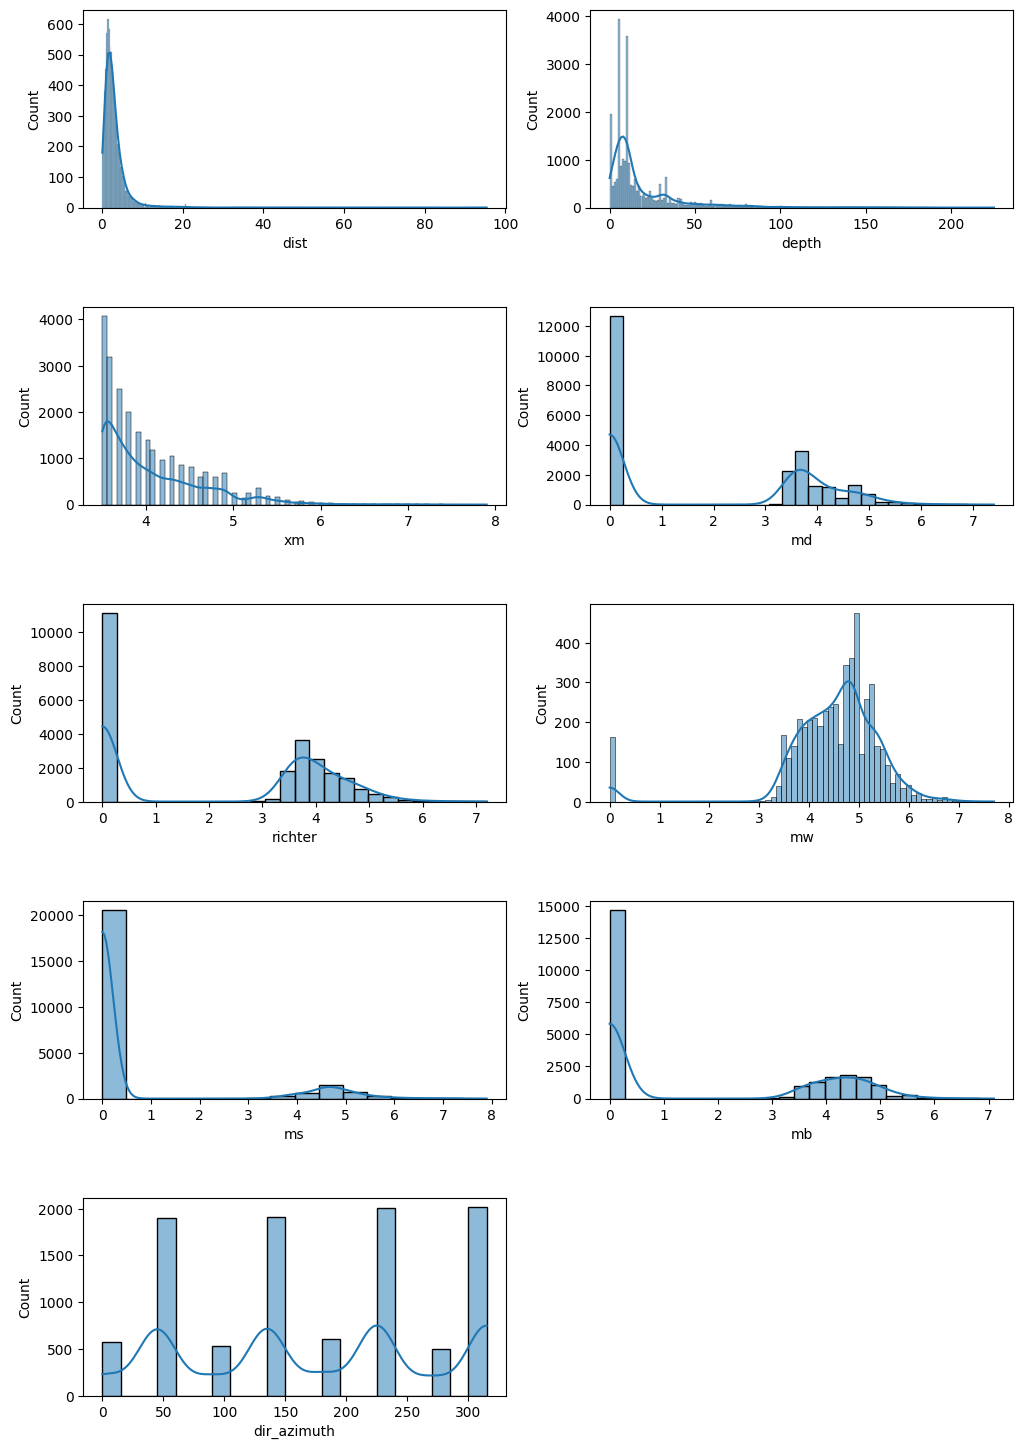

In [23]:
fig = plt.figure(figsize=(12,18))

cols = ['dist','depth', 'xm', 'md', 'richter', 'mw', 'ms', 'mb', 'dir_azimuth']

i=1
for col in cols:
  plt.subplot(5,2,i)
  sns.histplot(data=df,x=col, kde=True)
  i+=1
plt.subplots_adjust(hspace=0.5,wspace=0.2)
plt.show()

In [25]:
# Start by simply looking at number of earthquakes each year in dataset
year_quakes = df.groupby(df['datetime'].dt.year).size()

# Also calculate the ten-year moving average
tenyear_MA = year_quakes.rolling(10).mean()



In [26]:
border0_url = 'https://raw.githubusercontent.com/uyasarkocal/borders-of-turkey/master/lvl0-TR.geojson'
border1_url = 'https://raw.githubusercontent.com/uyasarkocal/borders-of-turkey/master/lvl1-TR.geojson'

border0 = gpd.read_file(border0_url)
border1 = gpd.read_file(border1_url)

# Check coordinate systems to ensure consistency
print(f'border0 CRS: {border0.crs}\n'
      f'border1 CRS: {border1.crs}\n')

border0 CRS: EPSG:4326
border1 CRS: EPSG:4326



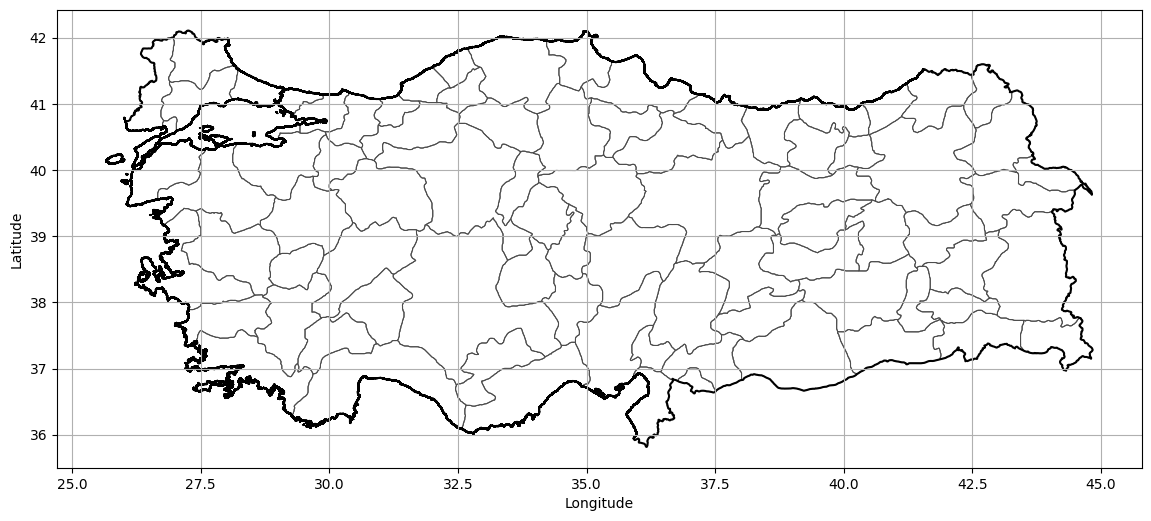

In [27]:
# Plot border data

fig, ax = plt.subplots(1, figsize=(14,14))
border1.plot(ax=ax, color='None', edgecolor=(0.3, 0.3, 0.3), linewidth=0.75)
border0.plot(ax=ax, color='None', edgecolor='black', linewidth=1.5);
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [28]:
# Convert our earthquake dataframe to a geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))


gdf = gdf.set_crs(epsg=4326)

print(f'gdf CRS: {gdf.crs}')
print(f'gdf total_bounds: {gdf.total_bounds}')

gdf CRS: EPSG:4326
gdf total_bounds: [18.34 29.74 48.   46.35]


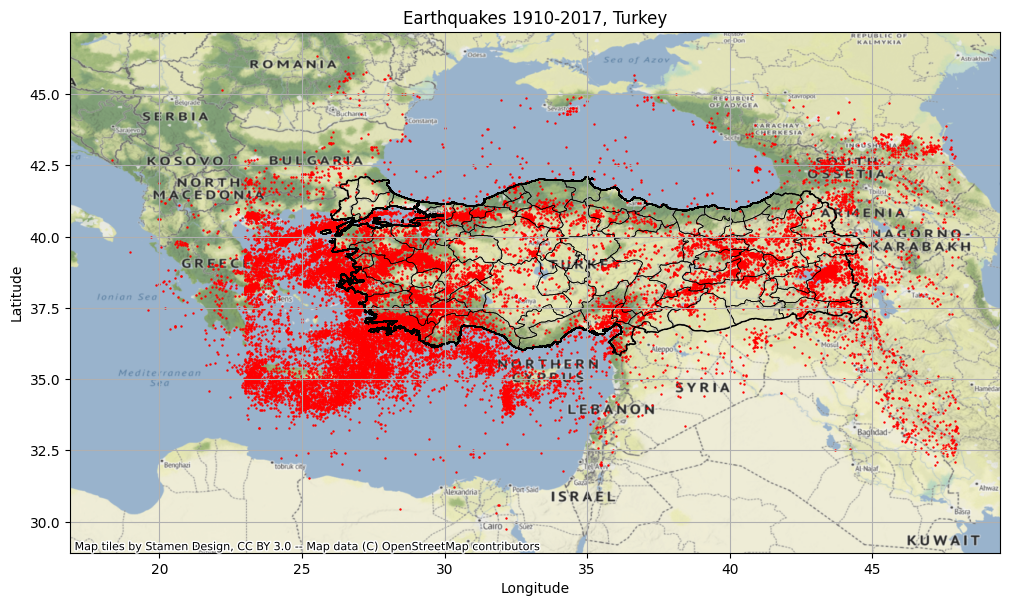

In [29]:
fig, ax = plt.subplots(1, figsize=(12,12))
gdf.plot(ax=ax, markersize=0.5, color='r')
border0.plot(ax=ax, color='None', edgecolor='k', linewidth=1)
border1.plot(ax=ax, color='None', edgecolor='k', linewidth=0.5)

# Also use contextily to add a basemap for additional geographic context
contextily.add_basemap(ax=ax, crs='epsg:4326')

plt.title('Earthquakes 1910-2017, Turkey')
plt.grid(True)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


**Tectonic plates** :
Pulling GeoJSON data showing the location of earth's tectonic plates

In [30]:
plates_url = 'https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_plates.json'
all_plates = gpd.read_file(plates_url)

# This dataset covers the whole earth. Let's filter it with the bounding box of the
# earthquake data
plates = all_plates.cx[gdf.total_bounds[0]:gdf.total_bounds[2], gdf.total_bounds[1]:gdf.total_bounds[3]]

In [33]:
# Define PROJECTED_CRS string variable to be used throughout rest of notebook

PROJECTED_CRS = 'ESRI:102422'
pyproj.CRS(PROJECTED_CRS)

<Projected CRS: ESRI:102422>
Name: WGS_1984_ARC_System_Zone_02
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: ARC System - Zone 2
- bounds: (-180.0, 32.0, 180.0, 48.0)
Coordinate Operation:
- name: WGS_1984_ARC_System_Zone_02
- method: Equidistant Cylindrical (Spherical)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
gdf_prj = gdf.to_crs(crs=PROJECTED_CRS)
border0_prj = border0.to_crs(crs=PROJECTED_CRS)
plates_prj = plates.to_crs(crs=PROJECTED_CRS)

print(gdf_prj['geometry'].head())
print('\nCRS Info:\n', gdf_prj.crs)

0    POINT (3385944.873 4345912.921)
1    POINT (2523107.509 4540722.029)
2    POINT (2315154.481 4294705.955)
3    POINT (3055567.884 4393780.302)
4    POINT (2535685.313 4541835.224)
Name: geometry, dtype: geometry

CRS Info:
 ESRI:102422


<ipython-input-35-e56b98f6a34a>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=gdf_prj['geometry'].x, y=gdf_prj['geometry'].y,


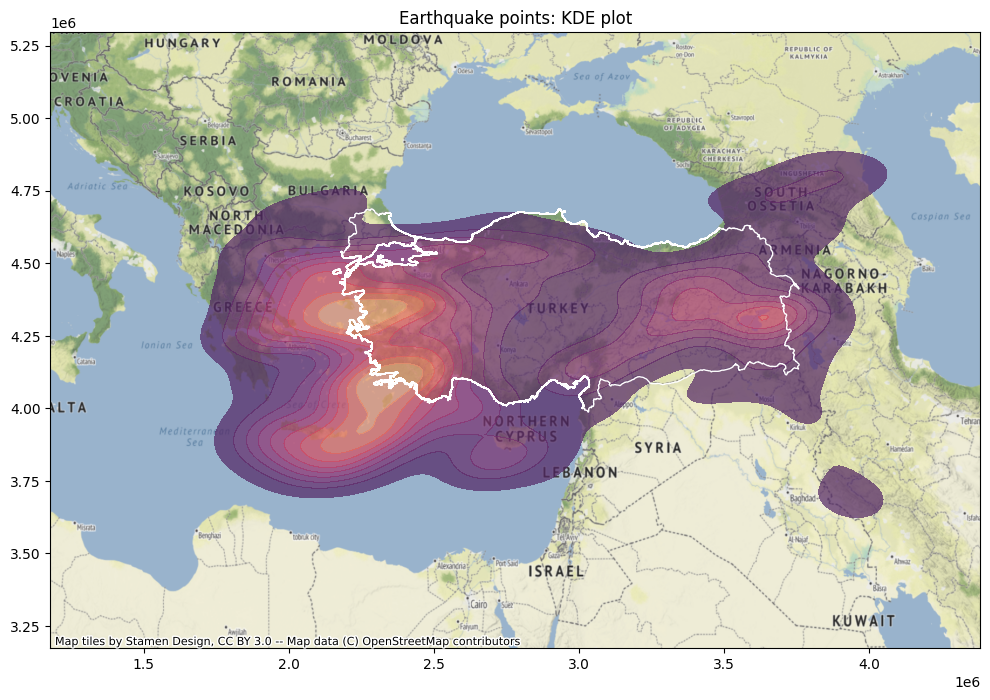

In [35]:

fig, ax = plt.subplots(1, figsize=(12,8))
sns.kdeplot(x=gdf_prj['geometry'].x, y=gdf_prj['geometry'].y,
            ax=ax, shade=True, cmap='flare_r', alpha=0.7)
border0_prj.plot(ax=ax, fc='None', ec='white')
ax.axis('equal')
contextily.add_basemap(ax=ax, crs=PROJECTED_CRS)
plt.title('Earthquake points: KDE plot')
plt.show()

In [37]:
earthquake_pts = np.array([gdf_prj['geometry'].x, gdf_prj['geometry'].y]).T


In [38]:
dbscan = DBSCAN(eps=15000, min_samples=100)
dbscan.fit(earthquake_pts)

DBSCAN(eps=15000, min_samples=100)

In [39]:
# Define function to plot dbscan results on a map

def plot_dbscan(points, dbscan, title, pt_sizer=1, plot_circles=False):
    noise = points[dbscan.labels_ == -1]
    clusters = points[dbscan.labels_ != -1]

    # Plot country border and tectonic plates
    fig, ax = plt.subplots(1, figsize=(12,8))
    border0_prj.plot(ax=ax, fc='None', ec='k', linewidth=1.5)
    plates_prj.plot(ax=ax, fc='None', ec='b', linestyle='-.')

    # Allow relative point size adjustment with pt_sizer argument
    sns.scatterplot(x=noise[:,0], y=noise[:,1], ax=ax, alpha=1, s=2*pt_sizer, color='gray')
    sns.scatterplot(x=clusters[:,0], y=clusters[:,1], ax=ax, s=4*pt_sizer, color='red')

    # Option to plot a minimum bounding circle around each cluster
    if plot_circles:
        for label in np.unique(dbscan.labels_):
            if label != -1:
                cluster_points = points[dbscan.labels_ == label]
                # Get minimum bounding circle using pointpats.centrography.minimum_bounding_circle()
                (center_x, center_y), radius = minimum_bounding_circle(cluster_points)
                # Create matplotlib patch
                circle_patch = mpatches.Circle((center_x, center_y), radius=radius, fc='None', ec='yellow', linewidth=2)
                ax.add_patch(circle_patch)

    ax.axis('equal')

    # Limit bounds of plot to earthquake data
    ax.set_xlim(gdf_prj.total_bounds[0], gdf_prj.total_bounds[2])
    ax.set_ylim(gdf_prj.total_bounds[1], gdf_prj.total_bounds[3])

    border0_l = mlines.Line2D([], [], color='k', linewidth=1.5, label='Turkey Border')
    plates_l = mlines.Line2D([], [], color='b', linestyle='-.', label='Tectonic Plates')
    noise_l = mlines.Line2D([], [], marker='.', linewidth=0, markersize=4,
                            color='gray', label='Noise')

    if plot_circles:
        # Draw yellow circle around red point for legend
        mec = 'yellow'
    else:
        mec = 'None'

    clusters_l = mlines.Line2D([], [], marker='.', linewidth=0,
                               markersize=12, color='red', markeredgecolor=mec,
                               label='DBSCAN Clusters')
    # Define legend
    plt.legend(handles=[border0_l, plates_l, noise_l, clusters_l])

    plt.title(title)

    # Add basemap
    contextily.add_basemap(ax=ax, crs=PROJECTED_CRS, alpha=0.5)

    plt.show()

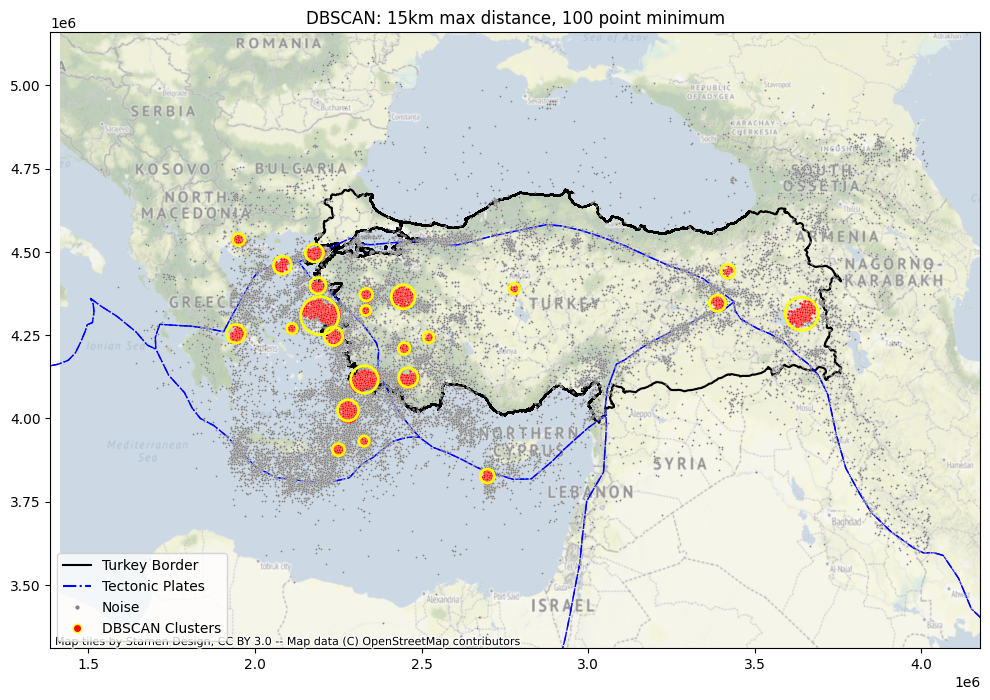

In [40]:
plot_dbscan(earthquake_pts, dbscan,
            title='',
            plot_circles=True)